### Data Cleaning and Text Preprocessing

In [16]:
import pandas as pd       
train = pd.read_csv("user_reviews.csv")

In [17]:
train.head()

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


In [18]:
train.shape

(2999, 4)

In [19]:
train["text"] = train["text"].str.lower().str.replace("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", case=False,regex=True)
train = train.drop_duplicates('text').reset_index(drop=True) # remove duplicates
train.shape # remove six duplicates

(2993, 4)

In [20]:
train['text'][0]

'my gf started playing before me no option to create my own island and guys being the 2nd player to start on a console sucks you miss out on so much that only the 1st player gets in terms of activities resources etc its absolutely terrible you have to buy a 2nd console if more than one person in your household wants to get the full game experience thats unacceptable'

In [32]:
from nltk.corpus import stopwords # Import the stop word list
import nltk
from bs4 import BeautifulSoup             

In [22]:
def review_to_wordlist( review, remove_stopwords=False, word_string=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #
    # 2. Convert words to lower case and split them
    words = review_text.split()
    #
    # 3. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 4. Return a list of words
    if word_string:  
    # the string make it easier to use in our Bag of Words
        return ( " ".join(words)) 
    
    return words

In [24]:
# Get the number of reviews based on the dataframe column size
num_UR = train["text"].size

# Initialize an empty list to hold the clean reviews
clean_train_UR = []

for i in range(num_UR):
    clean_train_UR.append(review_to_wordlist(train["text"][i],remove_stopwords=True,word_string=True))

In [25]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000)    #5000 most frequent words

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_UR)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [27]:
import numpy as np
import csv

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)
hot_words = pd.DataFrame({"Word":vocab,'Counts':dist})

In [28]:
hot_words = hot_words.sort_values('Counts', ascending = False)
# Top 10 key words in user reviews
hot_words[:10]

,Word,Counts
359,game,8645
460,island,3896
632,one,3171
846,switch,2176
668,play,2154
670,player,1785
612,nintendo,1666
659,per,1602
177,console,1443
609,new,1427


In [29]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

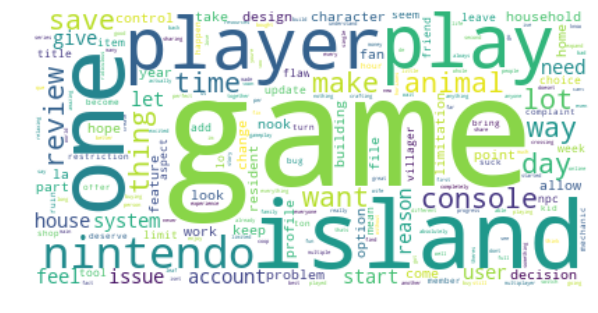

In [30]:
text = " ".join(review for review in hot_words['Word'])
wordcloud = WordCloud(background_color="white").generate(text)
fig = plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Using Word2Vec

Word2Vec expects single sentences, each one as a list of words. Thus the input format is a list of lists.

In [33]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [34]:
# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip()) # .strip removes the leading and ending spaces
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [35]:
review_to_sentences(train['text'][0], tokenizer, remove_stopwords=False )

[['my',
  'gf',
  'started',
  'playing',
  'before',
  'me',
  'no',
  'option',
  'to',
  'create',
  'my',
  'own',
  'island',
  'and',
  'guys',
  'being',
  'the',
  '2nd',
  'player',
  'to',
  'start',
  'on',
  'a',
  'console',
  'sucks',
  'you',
  'miss',
  'out',
  'on',
  'so',
  'much',
  'that',
  'only',
  'the',
  '1st',
  'player',
  'gets',
  'in',
  'terms',
  'of',
  'activities',
  'resources',
  'etc',
  'its',
  'absolutely',
  'terrible',
  'you',
  'have',
  'to',
  'buy',
  'a',
  '2nd',
  'console',
  'if',
  'more',
  'than',
  'one',
  'person',
  'in',
  'your',
  'household',
  'wants',
  'to',
  'get',
  'the',
  'full',
  'game',
  'experience',
  'thats',
  'unacceptable']]

In [36]:
# Preparing data for input to Word2Vec
sentences = []  # Initialize an empty list of sentences

for review in train["text"]:
    sentences += review_to_sentences(review, tokenizer)

In [37]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2020-05-18 16:44:48,049 : INFO : collecting all words and their counts
2020-05-18 16:44:48,049 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-18 16:44:48,115 : INFO : collected 13773 word types from a corpus of 360288 raw words and 2988 sentences
2020-05-18 16:44:48,116 : INFO : Loading a fresh vocabulary
2020-05-18 16:44:48,122 : INFO : effective_min_count=40 retains 871 unique words (6% of original 13773, drops 12902)
2020-05-18 16:44:48,123 : INFO : effective_min_count=40 leaves 312005 word corpus (86% of original 360288, drops 48283)
2020-05-18 16:44:48,125 : INFO : deleting the raw counts dictionary of 13773 items
2020-05-18 16:44:48,127 : INFO : sample=0.001 downsamples 73 most-common words
2020-05-18 16:44:48,128 : INFO : downsampling leaves estimated 203133 word corpus (65.1% of prior 312005)
2020-05-18 16:44:48,132 : INFO : estimated required memory for 871 words and 300 dimensions: 2525900 bytes
2020-05-18 16:44:48,133 : INFO : resetting la

Training model...


2020-05-18 16:44:48,315 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-18 16:44:48,319 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-18 16:44:48,322 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-18 16:44:48,322 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-18 16:44:48,323 : INFO : EPOCH - 1 : training on 360288 raw words (202830 effective words) took 0.2s, 1221211 effective words/s
2020-05-18 16:44:48,500 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-18 16:44:48,509 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-18 16:44:48,511 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-18 16:44:48,514 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-18 16:44:48,515 : INFO : EPOCH - 2 : training on 360288 raw words (203210 effective words) took 0.2s, 1107665 effective words/s


In [38]:
model.most_similar('player')

/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('resident', 0.9565224647521973),
 ('primary', 0.9429616928100586),
 ('limited', 0.9417286515235901),
 ('main', 0.9405830502510071),
 ('representative', 0.9269719123840332),
 ('basically', 0.9219245910644531),
 ('1st', 0.896396279335022),
 ('secondary', 0.8953644037246704),
 ('gets', 0.8946353197097778),
 ('progress', 0.8705273866653442)]

In [39]:
model.most_similar('terrible')

/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('limitation', 0.9400649666786194),
 ('ridiculous', 0.9352242946624756),
 ('limit', 0.919338583946228),
 ('coop', 0.9093043208122253),
 ('limiting', 0.9073451161384583),
 ('local', 0.9023050665855408),
 ('allowing', 0.8986147046089172),
 ('isnt', 0.8966097235679626),
 ('completely', 0.88721764087677),
 ('unplayable', 0.8838133811950684)]

In [40]:
model.most_similar('limitation')

/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('limit', 0.9487942457199097),
 ('terrible', 0.9400649666786194),
 ('ridiculous', 0.9267828464508057),
 ('1', 0.9034690856933594),
 ('shared', 0.8999577760696411),
 ('decision', 0.8933388590812683),
 ('issue', 0.8865048885345459),
 ('problem', 0.8807793855667114),
 ('user', 0.879791796207428),
 ('limiting', 0.8793298006057739)]